In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import scipy.stats
import collections

In [6]:
# read data

raw_df = pd.read_csv("raw_Mar31.csv", index_col=None)
for i, column in enumerate(raw_df.columns):
    end = "\n" if i % 5 == 0 and i > 0 else "\t"
    print(f"{column:30s}", end=end)
print()
print(f"total number of rows = {raw_df.shape[0]}")
n_videos = raw_df["Filename"].str.endswith(".mp4").sum()
n_videos_rp = ((raw_df != -1).all(axis=1) & raw_df["Filename"].str.endswith(".mp4")).sum()
print(f"total number of videos = {n_videos}")
print(f"total number of videos with RP output = {n_videos_rp}")

Filename                      	Advertiser                    	Date                          	Version                       	Country                       	Duration                      
Description                   	Brand/Product                 	ProductAdvertiser             	Title                         	Creative ID                   
Channel                       	Publication                   	Website                       	!!MISSING_KEY!! CreativeLabel_Outlet_PaidSocial	Ad Format                     
Endline                       	video_key                     	frames_analyzed               	(female, [0, 15), [-inf, 1.1))	(female, [0, 15), [1.1, 2.1)) 
(female, [0, 15), [2.1, 3.1)) 	(female, [0, 15), [3.1, 4.1)) 	(female, [0, 15), [4.1, 5.1)) 	(female, [0, 15), [5.1, 6.1)) 	(female, [0, 15), [6.1, 7.1)) 
(female, [0, 15), [7.1, 8.1)) 	(female, [0, 15), [8.1, 9.1)) 	(female, [15, 25), [-inf, 1.1))	(female, [15, 25), [1.1, 2.1))	(female, [15, 25), [2.1, 3.1))
(female, [15, 25), [3

In [35]:
# filter data

data_df = raw_df.loc[(raw_df != -1).all(axis=1) & raw_df["Filename"].str.endswith(".mp4")].copy()
data_df.index = pd.RangeIndex(0, len(data_df))
print(data_df.shape)

(7648, 148)


In [8]:
# check cross section bins count equals aggregates

def describe(row):
    print(row["Creative ID"])
    rp_columns = [column for column in row.index if re.match(r"\((fe)?male", column)]
    for column in rp_columns:
        if row[column] != 0:
            print(f"\t{column} : {row[column]}")
    print(f"faces : {row.faces}")
    print(f"gender : male = {row.masculine_faces}, female = {row.feminine_faces}")
    print("age : ")
    for j in range(7):
        count = row[f"age_{j + 1}"]
        end = ", " if j < 6 else "\n"
        print(f"age_{j + 1} = {count}", end=end)
    print("monk skin tone : ")
    for k in range(10):
        count = row[f"mst_scale_{k + 1}"]
        end = ", " if k < 9 else "\n"
        print(f"mst_scale_{k + 1} = {count}", end=end)

for _, row in data_df.iterrows():
    rp_data = np.zeros((2, 7, 10), dtype=int)
    for i, gender in enumerate(["male", "female"]):
        for j in range(7):
            for k in range(10):
                age_lb = 0 if j == 0 else 10 * j + 5
                age_ub = 10 * j + 15
                mst_lb = "-inf" if k == 0 else k + 0.1
                mst_ub = k + 1.1
                column_name = f"({gender}, [{age_lb}, {age_ub}), [{mst_lb}, {mst_ub}))"
                if column_name in row:
                    rp_data[i, j, k] = row[column_name]
    assert rp_data.sum() == row["faces"]
    assert rp_data[0].sum() == row["masculine_faces"]
    assert rp_data[1].sum() == row["feminine_faces"]
    for j in range(7):
        assert rp_data[:,j].sum() == row[f"age_{j + 1}"]
    # for k in range(10):
    #     assert rp_data[:, :, k].sum() == row[f"mst_scale_{k + 1}"]

In [96]:
# metadata

def target_gender(desc):
    desc = str(desc)
    f = re.search(r"(^|\s)(females?)|(wom(a|e)n)(\s|$)", desc.lower()) is not None
    m = re.search(r"(^|\s)((?<!fe)males?)|((?<!wo)m(a|e)n)(\s|$)", desc.lower()) is not None
    u = re.search(r"(^|\s)unisex(\s|$)", desc.lower()) is not None
    if f and not m and not u:
        return "female"
    elif m and not f:
        return "male"
    elif u and not f and not m:
        return "both"
    else:
        return "unspecified"

country_dist = sorted(collections.Counter(data_df["Country"]).items(), key=lambda x: x[1], reverse=True)
advertiser_dist = sorted(collections.Counter(data_df["ProductAdvertiser"]).items(), key=lambda x: x[1], reverse=True)
producttype_dist = sorted(collections.Counter(data_df["brand_category"]).items(), key=lambda x: x[1], reverse=True)
data_df["targetgender"] = data_df["Brand/Product"].apply(target_gender)
targetgender_dist = sorted(collections.Counter(data_df["targetgender"]).items(), key=lambda x: x[1], reverse=True)
total = len(data_df)

print("Country")
for i, (country, count) in enumerate(country_dist):
    per = 100*count/total
    end = "\n" if i % 5 == 0 and i > 0 else "\t"
    print(f"{country:10s} : {count:4d} ({per:4.1f}%)", end=end)
print("\n")

print("Advertiser")
for i, (advertiser, count) in enumerate(advertiser_dist):
    per = 100*count/total
    end = "\n" if i % 5 == 0 and i > 0 else "\t"
    print(f"{advertiser:10s} : {count:4d} ({per:4.1f}%)", end=end)
print("\n")

print("Product Type")
for i, (producttype, count) in enumerate(producttype_dist):
    per = 100*count/total
    end = "\n" if i % 5 == 0 and i > 0 else "\t"
    print(f"{producttype:10s} : {count:4d} ({per:4.1f}%)", end=end)
print("\n")

print("Target Gender")
for i, (targetgender, count) in enumerate(targetgender_dist):
    per = 100*count/total
    end = "\n" if i % 5 == 0 and i > 0 else "\t"
    print(f"{targetgender:10s} : {count:4d} ({per:4.1f}%)", end=end)

Country
Germany    : 3202 (41.9%)	UK         : 1715 (22.4%)	France     :  817 (10.7%)	Italy      :  806 (10.5%)	USA        :  701 ( 9.2%)	Spain      :  227 ( 3.0%)
Brazil     :   54 ( 0.7%)	India      :   49 ( 0.6%)	Mexico     :   46 ( 0.6%)	Indonesia  :   30 ( 0.4%)	Canada     :    1 ( 0.0%)


Advertiser
GARNIER    : 1825 (23.9%)	OAP        :  880 (11.5%)	LRP        :  631 ( 8.3%)	YSL        :  613 ( 8.0%)	VICHY      :  511 ( 6.7%)	LANCOME    :  504 ( 6.6%)
KIEHLS     :  429 ( 5.6%)	MNY        :  408 ( 5.3%)	MAYBELLINE :  346 ( 4.5%)	ARMANI     :  337 ( 4.4%)	KERASTASE  :  335 ( 4.4%)
NYX        :  286 ( 3.7%)	CERAVE     :  239 ( 3.1%)	LOP        :  110 ( 1.4%)	PRADA      :   84 ( 1.1%)	BIOTHERM   :   80 ( 1.0%)
REDKEN     :   30 ( 0.4%)	

Product Type
makeup     : 2897 (37.9%)	skincare   : 2429 (31.8%)	haircare   : 1640 (21.4%)	fragrance  :  682 ( 8.9%)	

Target Gender
unspecified : 4844 (63.3%)	female     : 2155 (28.2%)	male       :  460 ( 6.0%)	both       :  189 ( 2.5%)	

In [98]:
# rp_data rows x gender x age x skin tone

gender_cats = ["male", "female"]
age_cats = [(0, 15), (15, 25), (25, 35), (35, 45), (45, 55), (55, 65), (65, 75)]
age_cats2 = ["<15y", "15y-25y", "25y-35y", "35y-45y", "45y"]
skintone_cats = [(-np.inf, 1.1), (1.1, 2.1), (2.1, 3.1), (3.1, 4.1), (4.1, 5.1),
                 (5.1, 6.1), (6.1, 7.1), (7.1, 8.1), (8.1, 9.1), (9.1, 10.1)]
skintone_cats2 = ["light", "medium", "dark"]

rp_data = np.zeros((len(data_df), len(gender_cats), len(age_cats), len(skintone_cats)), dtype=int)

for i, row in data_df.iterrows():
    for j, gender in enumerate(gender_cats):
        for k, age_bin in enumerate(age_cats):
            age_lb, age_ub = age_bin
            for l, skintone_bin in enumerate(skintone_cats):
                skintone_lb, skintone_ub = skintone_bin
                column = f"({gender}, [{age_lb}, {age_ub}), [{skintone_lb}, {skintone_ub}))"
                if column in row.index:
                    rp_data[i, j, k, l] += row[column]

rp_data2 = np.zeros((len(data_df), len(gender_cats), len(age_cats2), len(skintone_cats2)), dtype=int)
rp_data2[:, :, :4, 0] = rp_data[:, :, :4, :3].sum(axis=3)
rp_data2[:, :, :4, 1] = rp_data[:, :, :4, 3:7].sum(axis=3)
rp_data2[:, :, :4, 2] = rp_data[:, :, :4, 7:].sum(axis=3)
rp_data2[:, :, 4, 0] = rp_data[:, :, 4:, :3].sum(axis=(2,3))
rp_data2[:, :, 4, 1] = rp_data[:, :, 4:, 3:7].sum(axis=(2, 3))
rp_data2[:, :, 4, 2] = rp_data[:, :, 4:, 7:].sum(axis=(2,3))

In [123]:
# metadata vs rp

def metadata_x_rp(df, rp_data, metadata, rp, confidence=0.05):
    assert rp in ["gender", "age", "skin tone"]
    assert metadata in ["country", "advertiser", "product type", "target gender"]
    if metadata == "country":
        column = "Country"
    elif metadata == "advertiser":
        column = "ProductAdvertiser"
    elif metadata == "product type":
        column = "brand_category"
    else:
        column = "targetgender"
    metadata_cat_to_count = collections.Counter(df[column])
    metadata_cats = [metadata_cat for metadata_cat, count in metadata_cat_to_count.items() if count >= 30]
    metadata_cats = sorted(metadata_cats, key=lambda x: metadata_cat_to_count[x], reverse=True)
    removed_metadata_cats = [x for x in df[column].unique() if x not in metadata_cats]
    print(f"{metadata} : {metadata_cats}")
    print(f"removed columns : {removed_metadata_cats}")
    if rp == "gender":
        rp_cats = gender_cats
    elif rp == "age":
        rp_cats = age_cats2
    else:
        rp_cats = skintone_cats2
    rp_arr = np.zeros((df[column].isin(metadata_cats).sum(), len(rp_cats)))
    metadata_arr = []

    j = 0
    for i, row in df.iterrows():
        metadata_value = row[column]
        if metadata_value in metadata_cats:
            metadata_arr.append(metadata_value)
            if rp == "gender":
                rp_arr[j] = 100 * rp_data[i].sum(axis=(1, 2))/rp_data[i].sum()
            elif rp == "age":
                rp_arr[j] = 100 * rp_data[i].sum(axis=(0, 2))/rp_data[i].sum()
            else:
                rp_arr[j] = 100 * rp_data[i].sum(axis=(0, 1))/rp_data[i].sum()
            j += 1
    metadata_arr = np.array(metadata_arr)
    
    plt.figure(figsize=(25, 10))
    colors = plt.get_cmap("Paired").colors
    x = np.arange(len(metadata_cats))
    bar_width = 0.8/len(rp_cats)
    for i, rp_cat in enumerate(rp_cats):
        rp_cat_arr = rp_arr[:, i]
        y = [rp_cat_arr[metadata_arr == metadata_cat].mean() for metadata_cat in metadata_cats]
        bc = plt.bar(x + i * bar_width, y, width=bar_width, label=str(rp_cat), color=colors[i])
        plt.bar_label(bc, [f"{yy:.1f}%" for yy in y], padding=5, rotation=90)
    plt.ylabel("average screen time")
    plt.xticks(x, metadata_cats)
    plt.xlabel(metadata)
    plt.title(f"distribution of {rp} screen time over {metadata}")
    plt.legend()
    plt.savefig(f"plots/{rp}_x_{metadata}.png")

    for i, rp_cat in enumerate(rp_cats):
        rp_cat_arr = rp_arr[:, i]
        metadata_to_rp_arr = {metadata_cat:rp_cat_arr[metadata_arr == metadata_cat] for metadata_cat in metadata_cats}
        metadata_sorted_by_mean = sorted(metadata_cats, key=lambda x: metadata_to_rp_arr[x].mean(), reverse=True)
        pvalues = []
        for j in range(len(metadata_cats) - 1):
            cat1, cat2 = metadata_sorted_by_mean[j], metadata_sorted_by_mean[j + 1]
            arr1, arr2 = metadata_to_rp_arr[cat1], metadata_to_rp_arr[cat2]
            _, pvalue = scipy.stats.ttest_ind(arr1, arr2, equal_var=False, alternative="greater")
            pvalues.append(pvalue)
        significant = np.array(pvalues)/(len(metadata_cats) - 1) < confidence
        print(f"{rp_cat} : ", end="")
        for j in range(len(metadata_cats) - 1):
            cat = metadata_sorted_by_mean[j]
            sign = ">" if significant[j] else "="
            print(f"{cat} {sign} ", end="")
        print(metadata_sorted_by_mean[-1])

country : ['Germany', 'UK', 'France', 'Italy', 'USA', 'Spain', 'Brazil', 'India', 'Mexico', 'Indonesia']
removed columns : ['Canada']
male : India > UK > France > Germany > USA > Italy > Brazil > Mexico = Spain > Indonesia
female : Indonesia > Spain = Mexico > Brazil > Italy > USA > Germany > France > UK > India


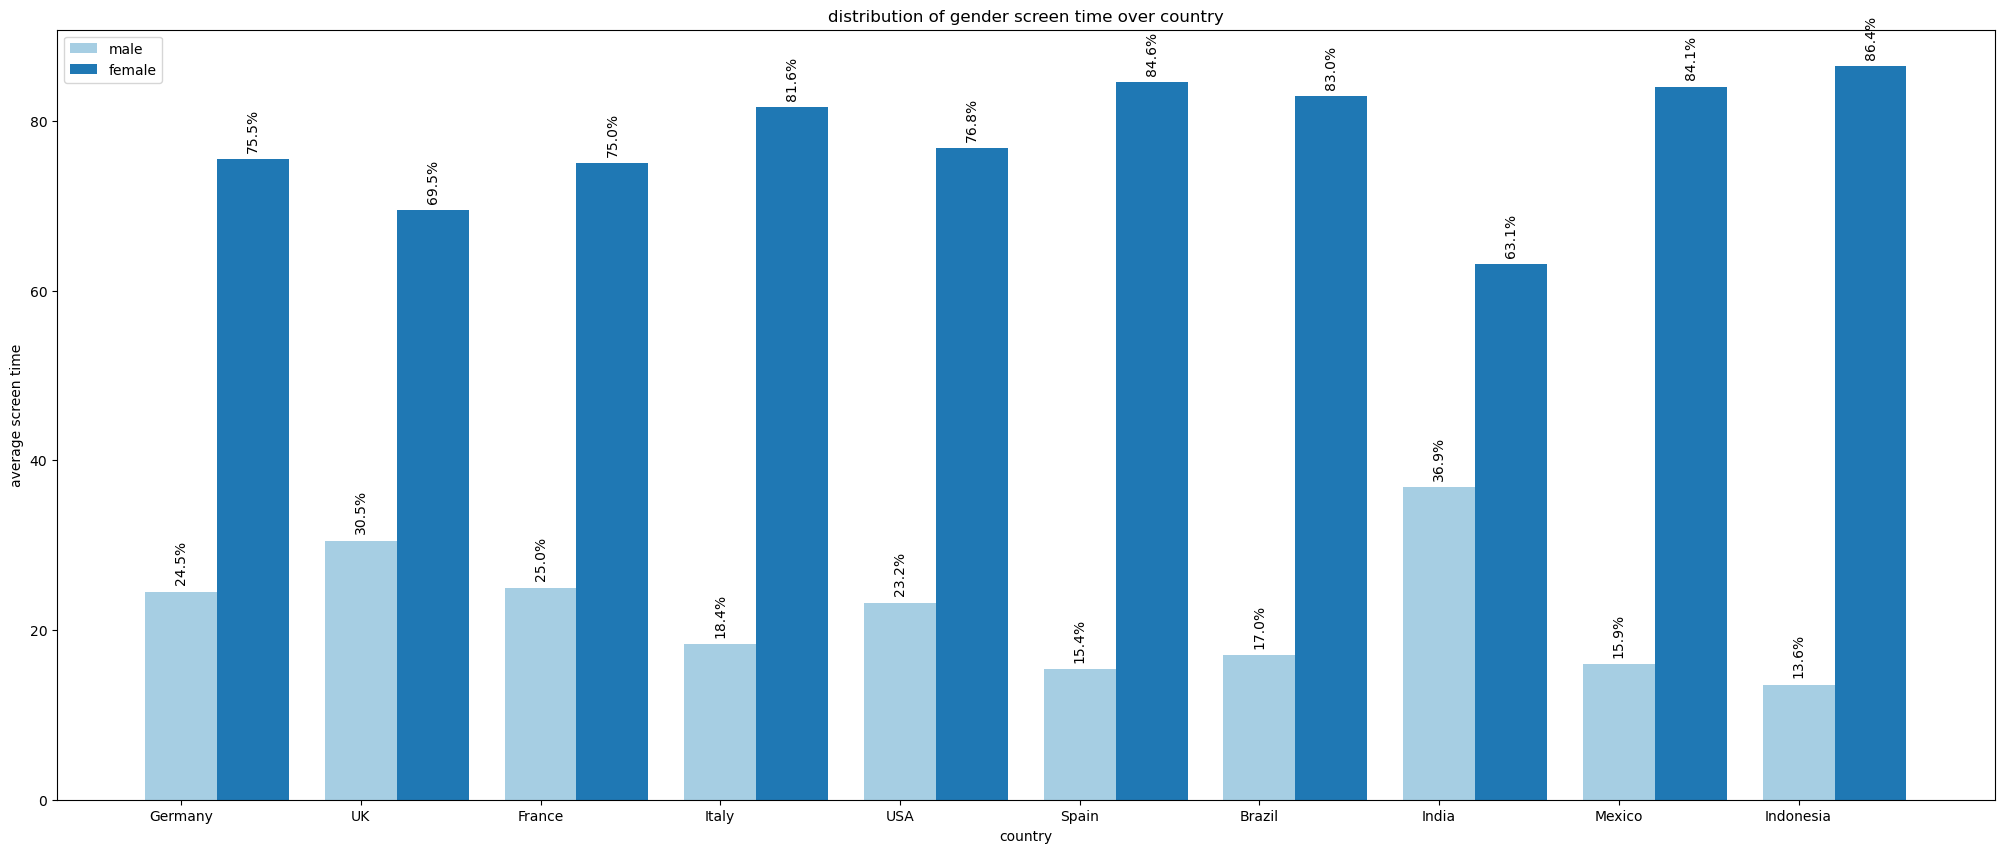

In [124]:
metadata_x_rp(data_df, rp_data2, "country", "gender")

country : ['Germany', 'UK', 'France', 'Italy', 'USA', 'Spain', 'Brazil', 'India', 'Mexico', 'Indonesia']
removed columns : ['Canada']
<15y : Germany > USA > UK = Italy > Spain > France > Indonesia > Brazil > Mexico > India
15y-25y : Brazil > USA > Germany > France > UK > Italy > Indonesia = Spain > Mexico > India
25y-35y : India > Indonesia > Mexico > Spain > Italy > France > UK > Germany = Brazil > USA
35y-45y : Mexico > India > UK > Spain > France > Germany > Italy = USA > Brazil > Indonesia
45y : Germany > UK = France > Spain = Italy > Mexico > USA > India > Brazil > Indonesia


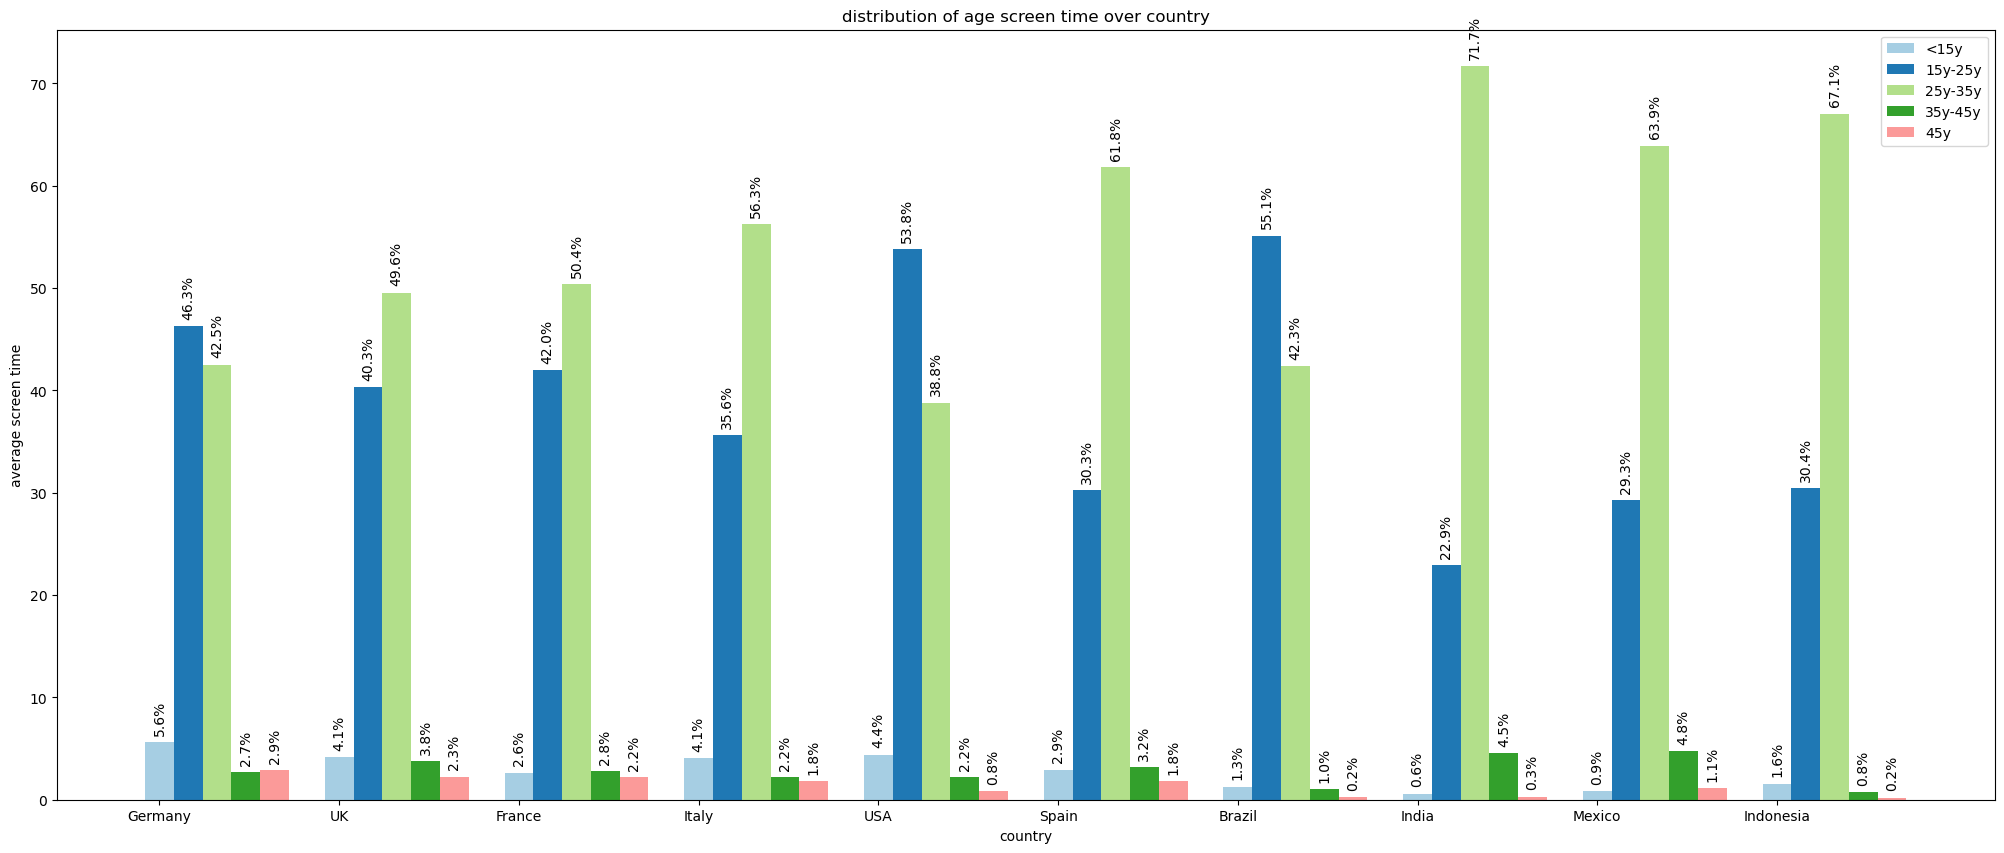

In [125]:
metadata_x_rp(data_df, rp_data2, "country", "age")

country : ['Germany', 'UK', 'France', 'Italy', 'USA', 'Spain', 'Brazil', 'India', 'Mexico', 'Indonesia']
removed columns : ['Canada']
light : Mexico = India > Indonesia > Spain > Italy > Germany > France > Brazil > UK > USA
medium : USA > UK > Brazil > Germany > France > Italy > Spain > Indonesia > India > Mexico
dark : USA > UK > France > Brazil > Italy > Germany > Spain > Indonesia > Mexico > India


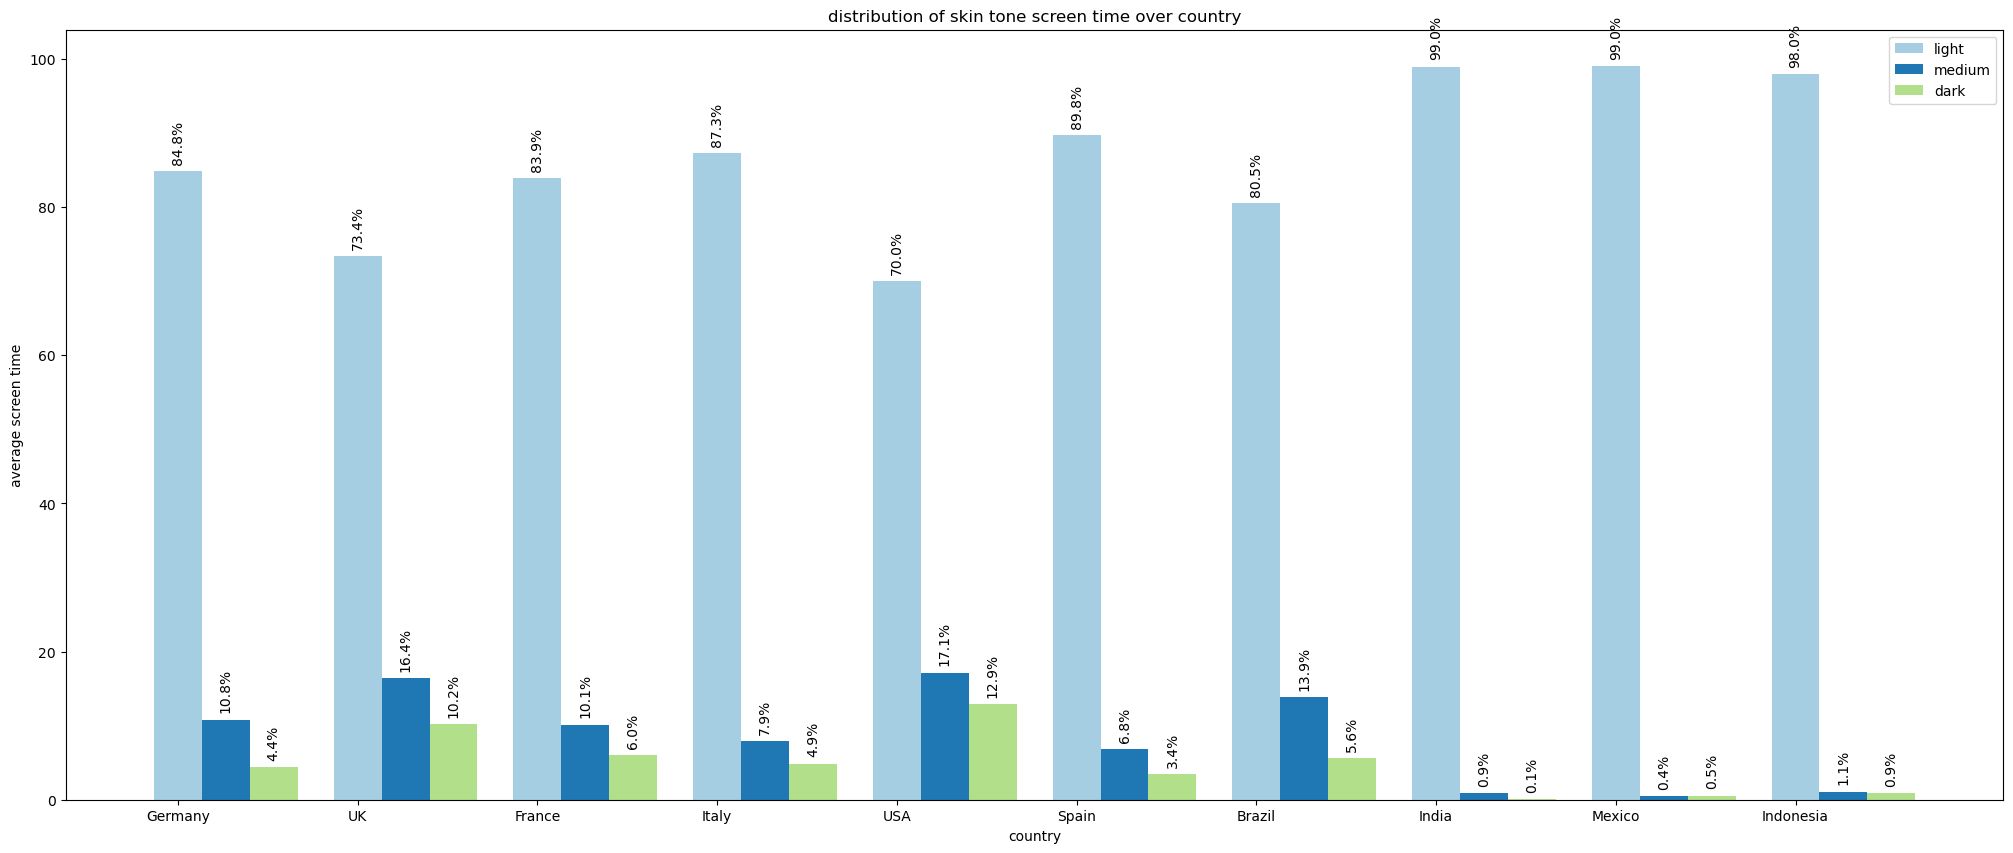

In [126]:
metadata_x_rp(data_df, rp_data2, "country", "skin tone")

advertiser : ['GARNIER', 'OAP', 'LRP', 'YSL', 'VICHY', 'LANCOME', 'KIEHLS', 'MNY', 'MAYBELLINE', 'ARMANI', 'KERASTASE', 'NYX', 'CERAVE', 'LOP', 'PRADA', 'BIOTHERM', 'REDKEN']
removed columns : []
male : PRADA > ARMANI > LRP > VICHY > OAP > YSL > CERAVE > KIEHLS > NYX > KERASTASE > GARNIER > BIOTHERM > LOP > LANCOME > REDKEN > MAYBELLINE > MNY
female : MNY > MAYBELLINE > REDKEN > LANCOME > LOP > BIOTHERM > GARNIER > KERASTASE > NYX > KIEHLS > CERAVE > YSL > OAP > VICHY > LRP > ARMANI > PRADA


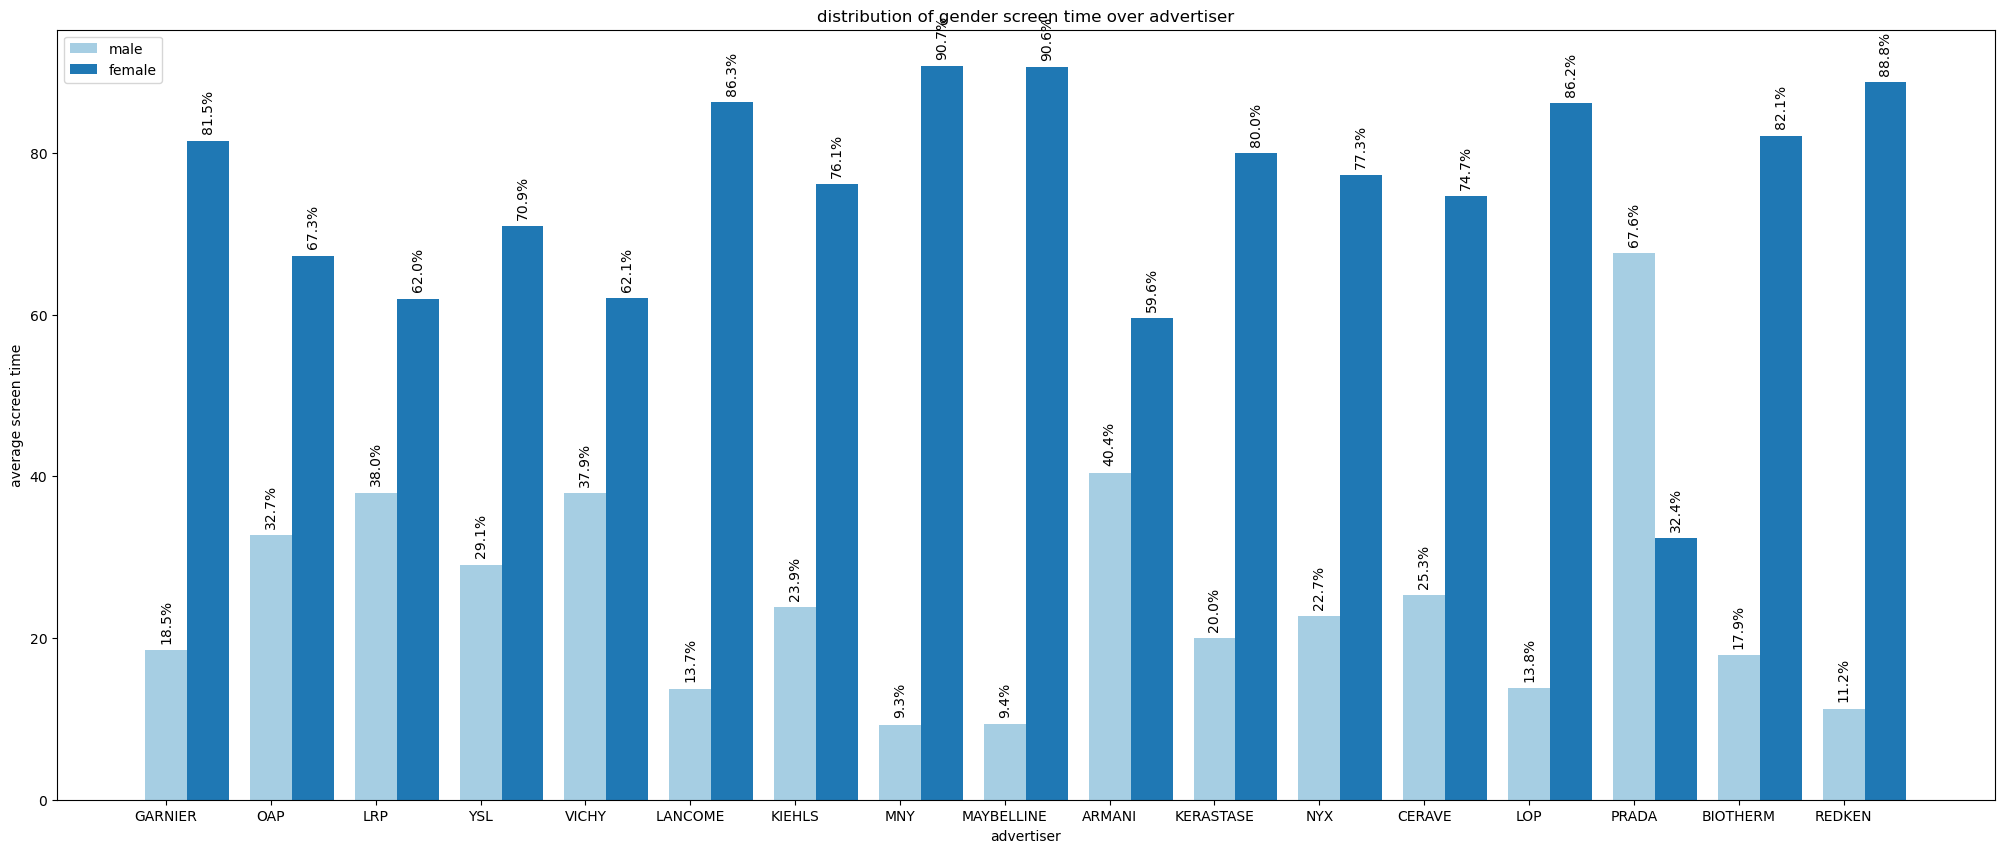

In [127]:
metadata_x_rp(data_df, rp_data2, "advertiser", "gender")

advertiser : ['GARNIER', 'OAP', 'LRP', 'YSL', 'VICHY', 'LANCOME', 'KIEHLS', 'MNY', 'MAYBELLINE', 'ARMANI', 'KERASTASE', 'NYX', 'CERAVE', 'LOP', 'PRADA', 'BIOTHERM', 'REDKEN']
removed columns : []
<15y : CERAVE > GARNIER > NYX > MNY > LOP > LRP > MAYBELLINE > YSL > KERASTASE > PRADA > KIEHLS > REDKEN > VICHY > ARMANI > BIOTHERM > OAP > LANCOME
15y-25y : MNY > LOP > REDKEN > NYX > YSL > MAYBELLINE > KERASTASE > LRP > GARNIER > BIOTHERM > VICHY > CERAVE > LANCOME > ARMANI > KIEHLS > OAP > PRADA
25y-35y : PRADA > ARMANI > OAP > LANCOME > BIOTHERM > CERAVE > VICHY > KIEHLS > GARNIER > LRP > KERASTASE > MAYBELLINE > YSL > NYX > LOP > MNY > REDKEN
35y-45y : REDKEN > KIEHLS > OAP > VICHY > LANCOME > BIOTHERM > KERASTASE > ARMANI > CERAVE > PRADA > LRP > NYX > MNY > YSL > LOP > GARNIER > MAYBELLINE
45y : KIEHLS > VICHY > OAP > KERASTASE > ARMANI > YSL > BIOTHERM > LRP > MNY > LANCOME > NYX > GARNIER > MAYBELLINE > CERAVE > LOP > PRADA > REDKEN


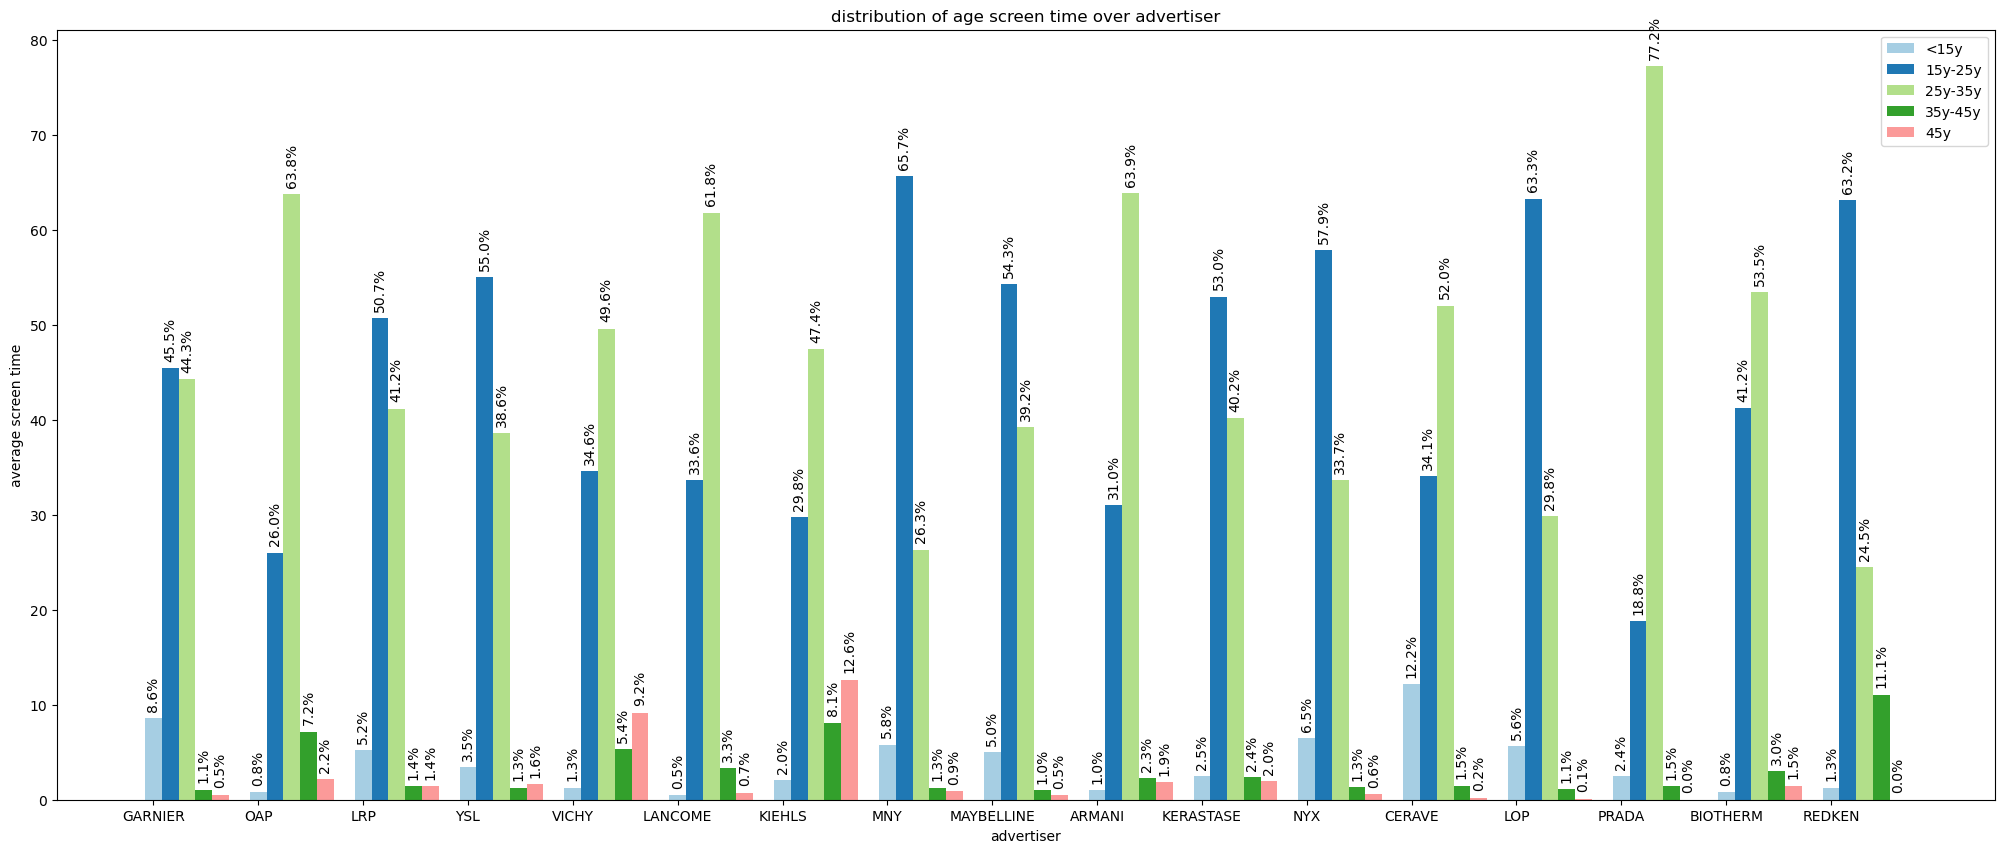

In [128]:
metadata_x_rp(data_df, rp_data2, "advertiser", "age")

advertiser : ['GARNIER', 'OAP', 'LRP', 'YSL', 'VICHY', 'LANCOME', 'KIEHLS', 'MNY', 'MAYBELLINE', 'ARMANI', 'KERASTASE', 'NYX', 'CERAVE', 'LOP', 'PRADA', 'BIOTHERM', 'REDKEN']
removed columns : []
light : LOP > CERAVE > KERASTASE > BIOTHERM > VICHY > PRADA > REDKEN > GARNIER > MNY > LANCOME > OAP > LRP > KIEHLS > ARMANI > MAYBELLINE > YSL > NYX
medium : KIEHLS > NYX > MAYBELLINE > REDKEN > MNY > OAP > ARMANI > LRP > LANCOME > GARNIER > YSL > VICHY > PRADA > LOP > CERAVE > KERASTASE > BIOTHERM
dark : YSL > NYX > ARMANI > LRP > MAYBELLINE > PRADA > BIOTHERM > KIEHLS > OAP > GARNIER > KERASTASE > LANCOME > VICHY > MNY > CERAVE > LOP > REDKEN


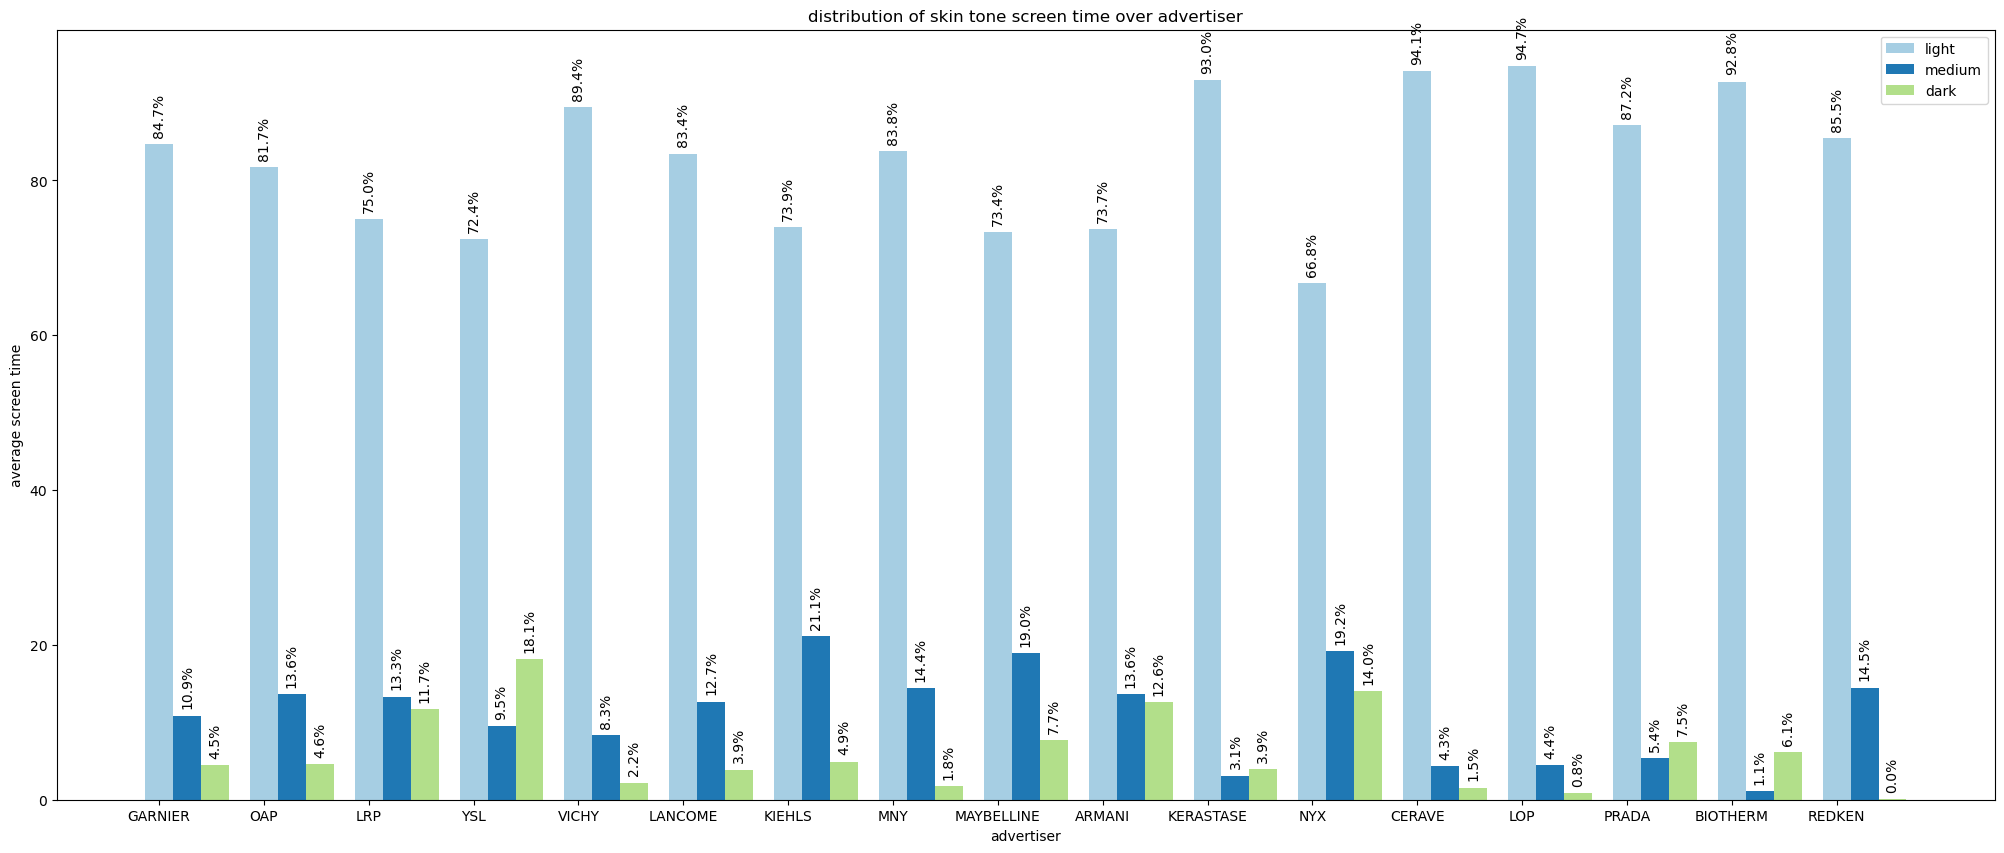

In [129]:
metadata_x_rp(data_df, rp_data2, "advertiser", "skin tone")

product type : ['makeup', 'skincare', 'haircare', 'fragrance']
removed columns : []
male : fragrance > skincare > makeup > haircare
female : haircare > makeup > skincare > fragrance


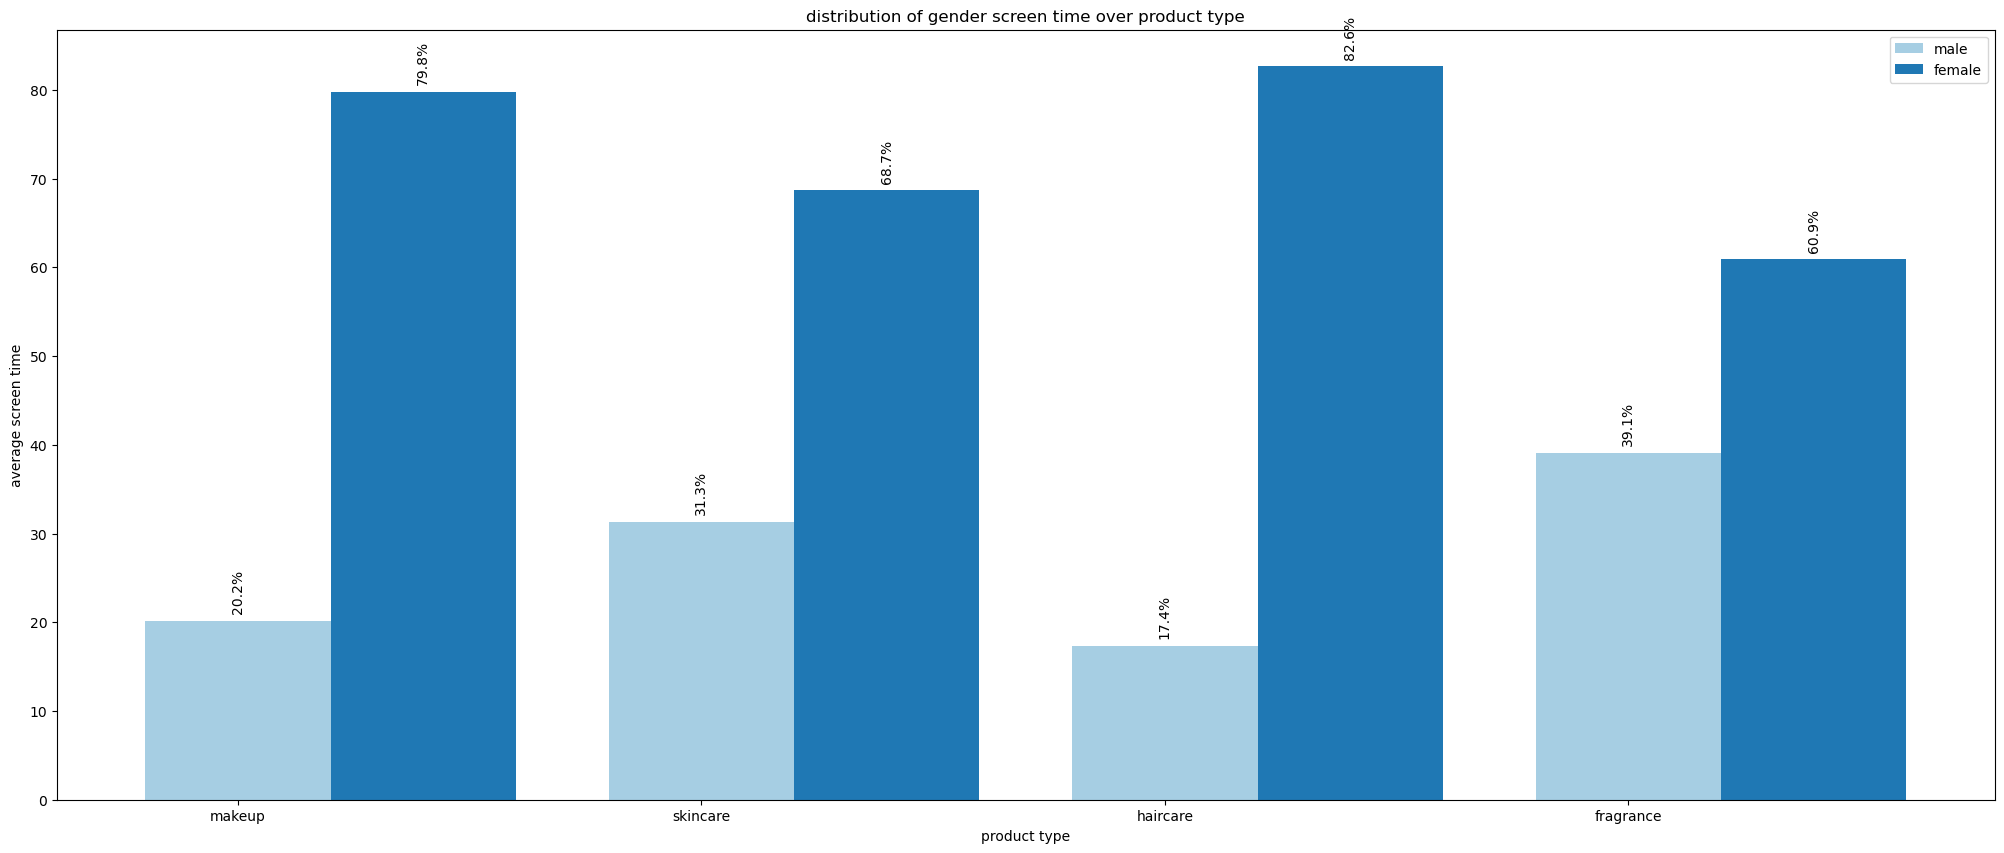

In [130]:
metadata_x_rp(data_df, rp_data2, "product type", "gender")

product type : ['makeup', 'skincare', 'haircare', 'fragrance']
removed columns : []
<15y : makeup = haircare > skincare > fragrance
15y-25y : makeup > haircare > skincare > fragrance
25y-35y : fragrance > skincare > haircare > makeup
35y-45y : skincare > fragrance > makeup > haircare
45y : skincare > makeup > fragrance > haircare


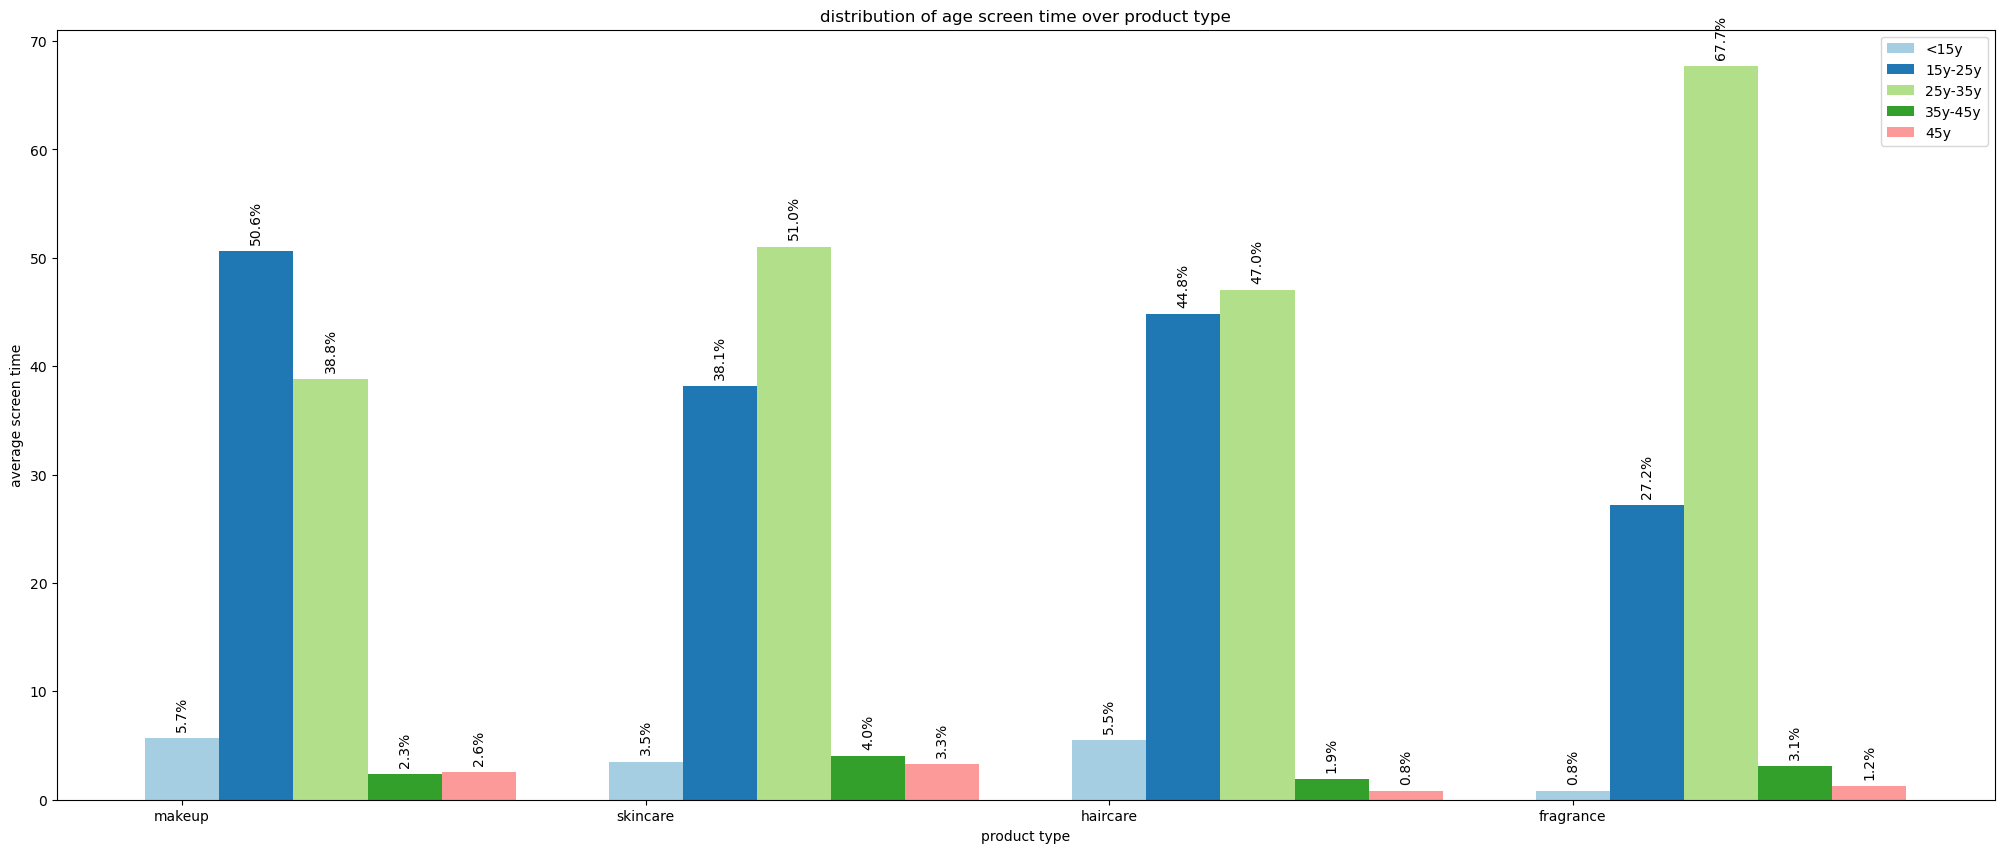

In [131]:
metadata_x_rp(data_df, rp_data2, "product type", "age")

product type : ['makeup', 'skincare', 'haircare', 'fragrance']
removed columns : []
light : haircare > fragrance > skincare > makeup
medium : makeup > skincare > haircare > fragrance
dark : fragrance > makeup > skincare > haircare


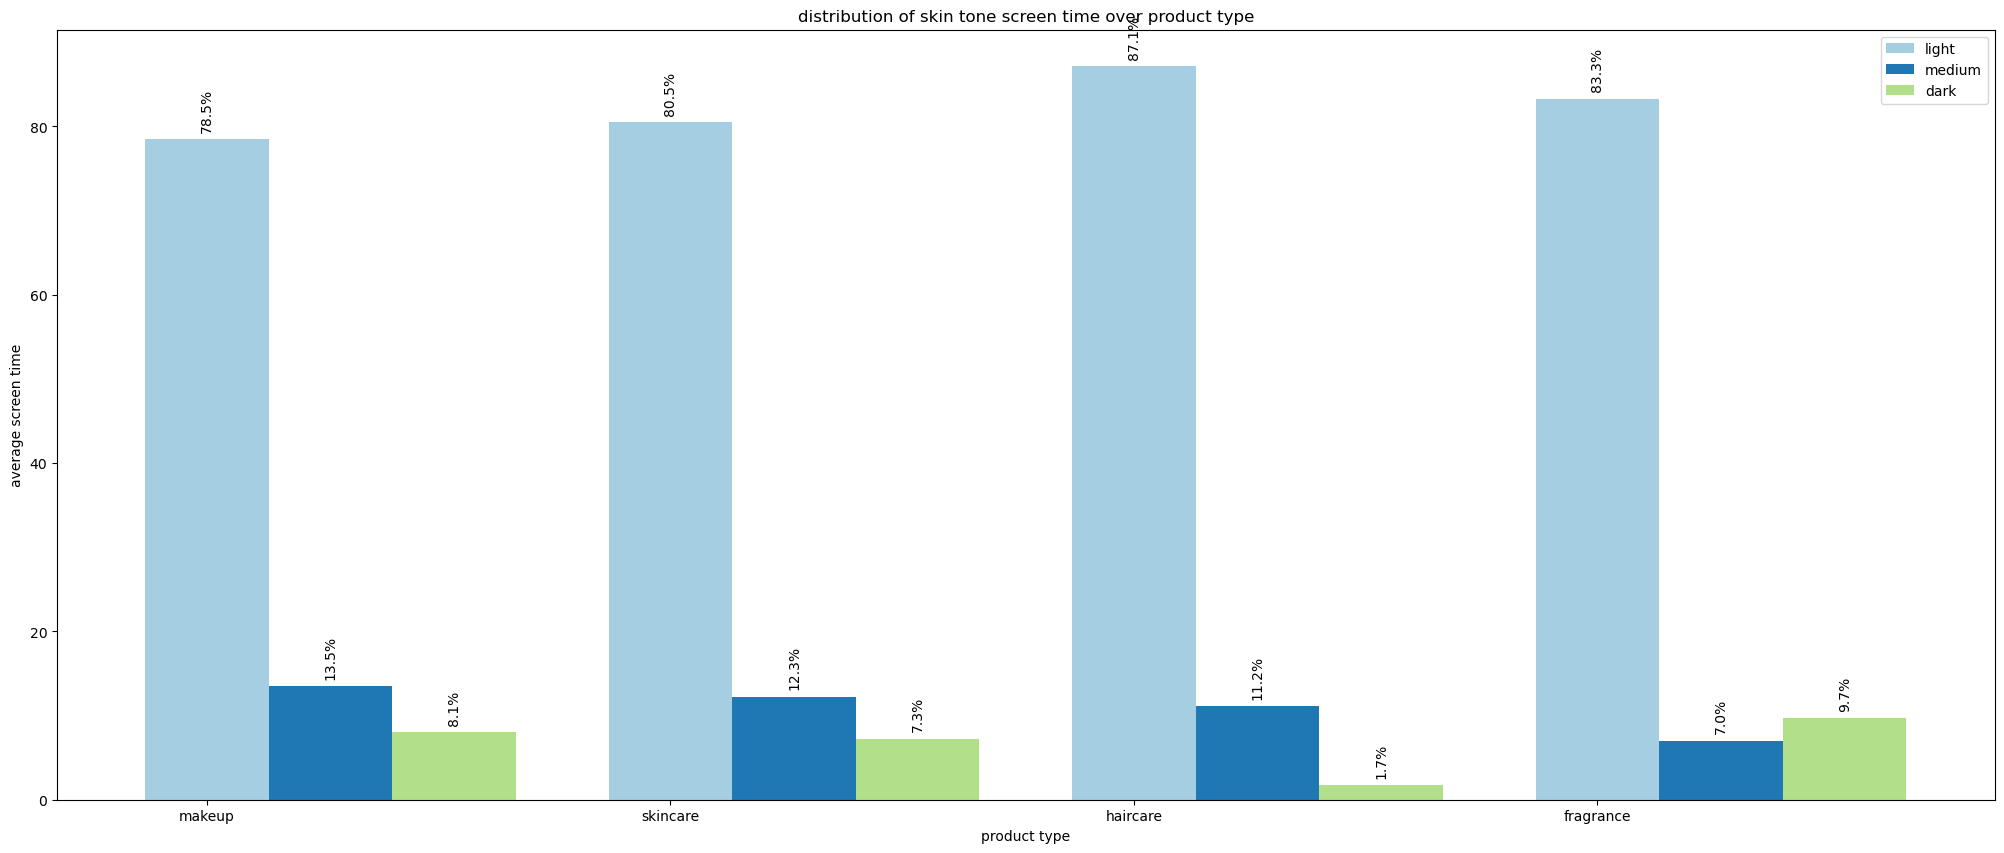

In [132]:
metadata_x_rp(data_df, rp_data2, "product type", "skin tone")

target gender : ['unspecified', 'female', 'male', 'both']
removed columns : []
male : male > both > female > unspecified
female : unspecified > female > both > male


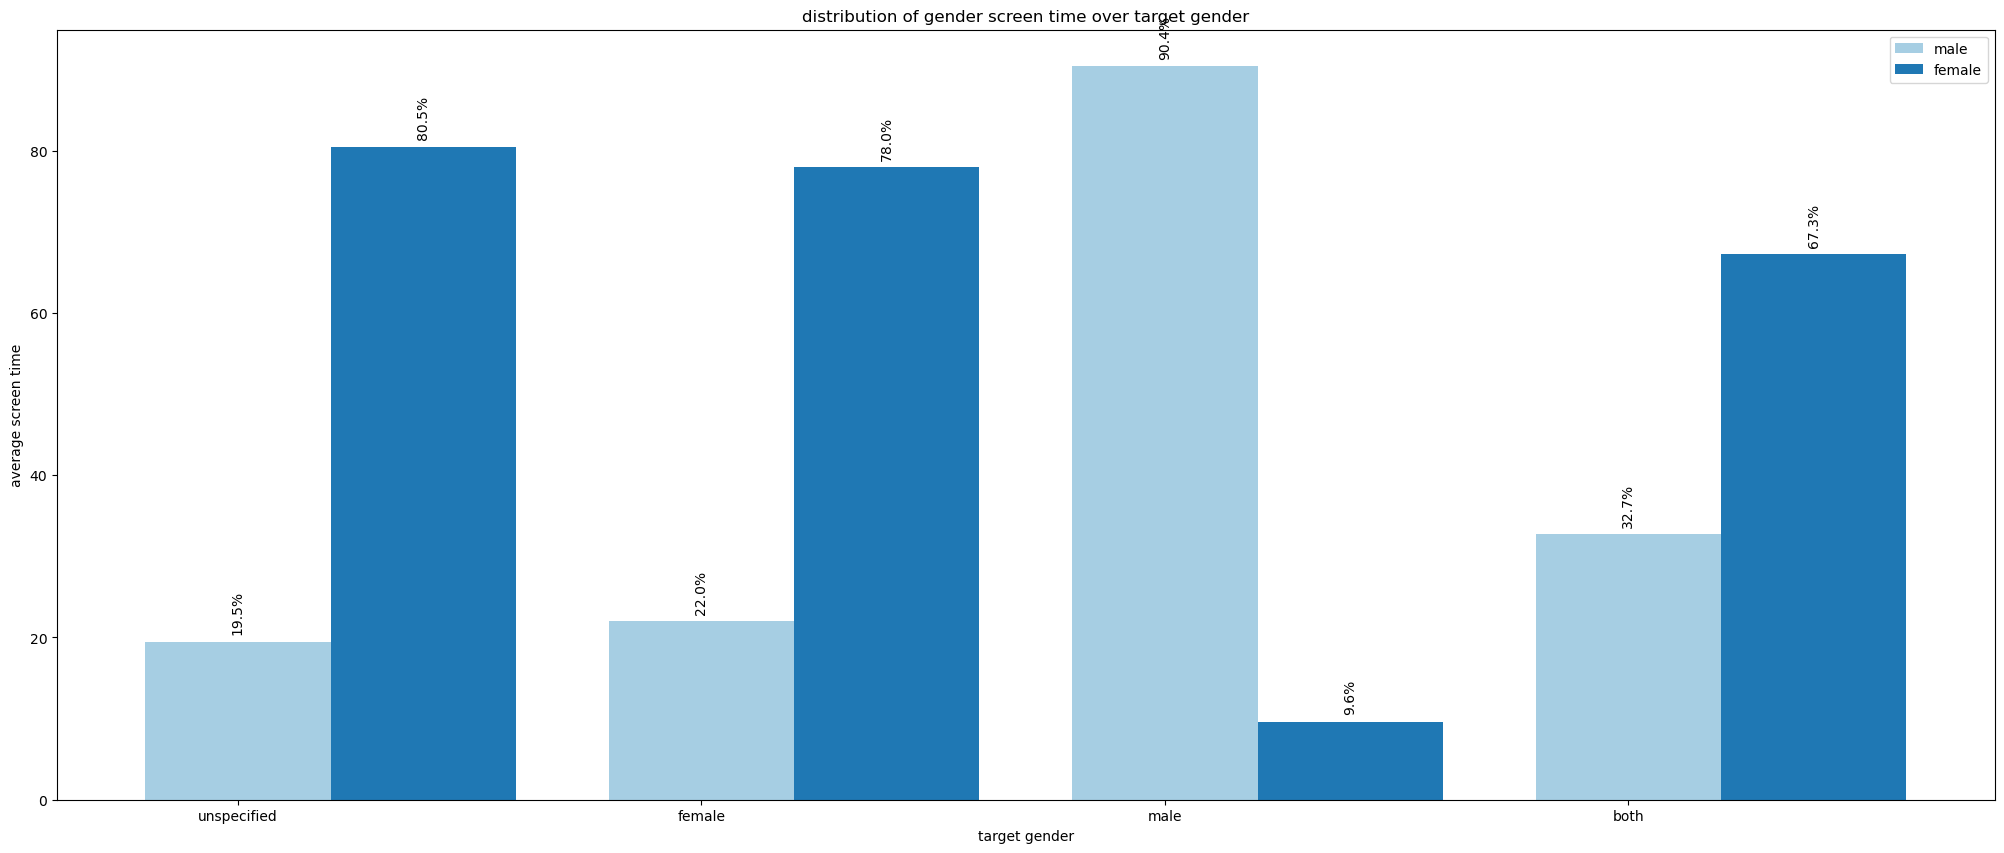

In [133]:
metadata_x_rp(data_df, rp_data2, "target gender", "gender")